# Counter-Clockwise Loops to Find Neighbourhood Blocks

In [56]:
#!/usr/bin/env python
# coding: utf-8

"""
Find house blocks in osmnx graphs.
"""

'\nFind house blocks in osmnx graphs.\n'

In [57]:
import numpy as np
import networkx as nx
import osmnx as ox
import geopandas as gpd

In [58]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [59]:
from shapely.geometry import Point, LineString, Polygon, MultiLineString

In [60]:
ox.config(log_console=True, use_cache=True)

In [61]:
def k_core(G, k):
    H = nx.Graph(G, as_view=True)
    H.remove_edges_from(nx.selfloop_edges(H))
    core_nodes = nx.k_core(H, k)
    H = H.subgraph(core_nodes)
    return G.subgraph(core_nodes)

In [62]:
def get_vector(G, n1, n2):
    dx = np.diff([G.nodes.data()[n]['x'] for n in (n1, n2)])
    dy = np.diff([G.nodes.data()[n]['y'] for n in (n1, n2)])
    return np.array([dx, dy])

In [63]:
def angle_between(v1, v2):
    # https://stackoverflow.com/a/31735642/2912349
    ang1 = np.arctan2(*v1[::-1])
    ang2 = np.arctan2(*v2[::-1])
    return (ang1 - ang2) % (2 * np.pi)

In [64]:
def step_counterclockwise(G, edge, path):
    start, stop = edge
    v1 = get_vector(G, stop, start)
    neighbors = set(G.neighbors(stop))
    candidates = list(set(neighbors) - set([start]))
    if not candidates:
        raise Exception("Ran into a dead end!")
    else:
        angles = np.zeros_like(candidates, dtype=float)
        for ii, neighbor in enumerate(candidates):
            v2 = get_vector(G, stop, neighbor)
            angles[ii] = angle_between(v1, v2)
        next_node = candidates[np.argmin(angles)]
        if next_node in path:
            # next_node might not be the same as the first node in path;
            # therefor, we backtrack until we end back at next_node
            closed_path = [next_node]
            for node in path[::-1]:
                closed_path.append(node)
                if node == next_node:
                    break
            return closed_path[::-1] # reverse to have counterclockwise path
        else:
            path.append(next_node)
            return step_counterclockwise(G, (stop, next_node), path)

In [65]:
def get_city_block_patch(G, boundary_nodes, *args, **kwargs):
    xy = []
    for node in boundary_nodes:
        x = G.nodes.data()[node]['x']
        y = G.nodes.data()[node]['y']
        xy.append((x, y))
    path = Path(xy, closed=True)
    return PathPatch(path, *args, **kwargs)

In [66]:
G = ox.load_graphml('network.graphml')

In [67]:
H = k_core(G, 2)

In [68]:
# get color map
cmap = cm.get_cmap('tab20c', len(H.edges) + 1)

In [69]:
fig1, ax1 = ox.plot_graph(
    G, edge_color='k', edge_linewidth=1, show=False)

In [70]:
def get_city_block_polygon(G, boundary_nodes, *args, **kwargs):
    xy = []
    for node in boundary_nodes:
        x = G.nodes.data()[node]['x']
        y = G.nodes.data()[node]['y']
        xy.append((x,y))
    polygon = Polygon(xy)
    return polygon

In [71]:
block_steps = []
block_polygons = []
block_patches = []

for i, edge in enumerate(H.edges):
    start, stop, _ = edge

    steps = step_counterclockwise(H, (start, stop), [start, stop])

    # --------------------------------------------------------------------------------
    # plot

    patch = get_city_block_patch(
        G, steps, facecolor=cmap.colors[i], edgecolor=cmap.colors[i], zorder=-1)

    node_size = [100 if node in steps else 20 for node in G.nodes]
    node_color = [cmap.colors[i] if node in steps else 'black' for node in G.nodes]

    block_steps.append(steps)
    block_polygons.append(get_city_block_polygon(G,steps))
    block_patches.append(patch)
#     ax1.add_patch(patch)

In [72]:
for patch in block_patches:
    ax1.add_patch(patch)

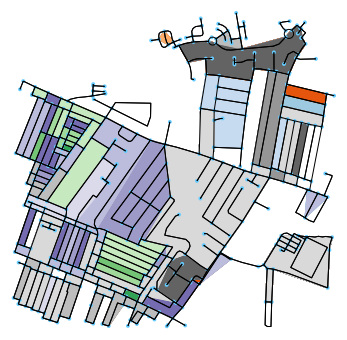

In [73]:
fig1